# ATP Tennis Data - Raw Player Stats + One Hot Encoding + Player History


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.0.2-atp_ohe.ipynb), we got the best performance when we used raw player stats and one hot encoded our categorical data

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/3.1.0-apt_feature_engineering-history.ipynb) where we aggregated match data for each player for the most recent 5 matches leading up to sample in our data

History data that we obtained for both players:

* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost

Percentage Data:
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

Diff data:
* p1_history_win_percentage_diff - player 1 win percentage history - player 2 win percentage history
* p1_history_games_won_percentage_diff = player 1 games won percentage - player 2 games won percentage
* p1_history_sets_won_percentage_diff = player 1 sets won percetntage - player 2 sets won percentage
* p1_history_wins_diff = player 1 wins - player 2 wins
* p1_history_losses_diff = player 1 losses - player 2 losses


We will put all of these columns in our dataset and run it through our models to see if there are improvements

### Results from previous best model

```
Model Score: 0.6833220796758946

ROC/AUC Score: 0.6833051847604916
              precision    recall  f1-score   support

        Loss       0.68      0.68      0.68      7381
         Win       0.68      0.69      0.69      7429

    accuracy                           0.68     14810
   macro avg       0.68      0.68      0.68     14810
weighted avg       0.68      0.68      0.68     14810
```

# Summary of Results

* Grandient Boosting is still our best model
* Adding history data for both players increased accuracy slightly for all models except for Decision Tree and KNN

```
Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-history_all"


# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-ohe-history5-matchup5-stats5.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"
else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5-stats5.csv'


START_YEAR = 1998
END_YEAR = 2018




In [2]:
import re

def filter_features(data: pd.DataFrame):
    print(f'Before: data.shape {data.shape} data.shape {data.shape}')
    
    matchup_columns = [col for col in data.columns if re.search("matchup", col)]
    data = data.drop(matchup_columns, axis=1)
    
    stats_columns = [col for col in data.columns if re.search("stats", col)]
    data = data.drop(stats_columns, axis=1)
    
    print(f'After: data.shape {data.shape} data.shape {data.shape}')
    
    return data
    

In [3]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, data_filter = filter_features)

Before: data.shape (46, 391) X_test.shape (46, 391)
After: data.shape (46, 302) X_test.shape (46, 302)


In [4]:
[col for col in X_train.columns if re.search("history", col)]

['p1_history_games_lost',
 'p1_history_games_won',
 'p1_history_games_won_percentage',
 'p1_history_losses',
 'p1_history_sets_lost',
 'p1_history_sets_won',
 'p1_history_sets_won_percentage',
 'p1_history_win_percentage',
 'p1_history_wins',
 'p2_history_games_lost',
 'p2_history_games_won',
 'p2_history_games_won_percentage',
 'p2_history_losses',
 'p2_history_sets_lost',
 'p2_history_sets_won',
 'p2_history_sets_won_percentage',
 'p2_history_win_percentage',
 'p2_history_wins',
 'p1_history_win_percentage_diff',
 'p1_history_games_won_percentage_diff',
 'p1_history_sets_won_percentage_diff',
 'p1_history_wins_diff',
 'p1_history_losses_diff',
 'p1_history_matches',
 'p2_history_matches']

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_lr = lr.predict()

[LibLinear]

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Model Score: 0.5833333333333334

ROC/AUC Score: 0.5625
              precision    recall  f1-score   support

        Loss       0.40      0.50      0.44         4
         Win       0.71      0.62      0.67         8

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.61      0.58      0.59        12

      Loss  Win
Loss     2    2
Win      3    5


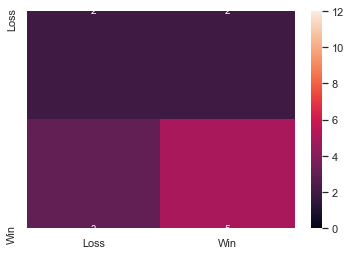

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary-test.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_knn = knn.predict()

Model Score: 0.8333333333333334

ROC/AUC Score: 0.75
              precision    recall  f1-score   support

        Loss       1.00      0.50      0.67         4
         Win       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12

      Loss  Win
Loss     2    2
Win      0    8


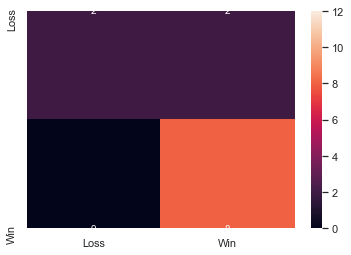

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary-test.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_dt = dt.predict()

Model Score: 0.5833333333333334

ROC/AUC Score: 0.5
              precision    recall  f1-score   support

        Loss       0.33      0.25      0.29         4
         Win       0.67      0.75      0.71         8

    accuracy                           0.58        12
   macro avg       0.50      0.50      0.50        12
weighted avg       0.56      0.58      0.57        12

      Loss  Win
Loss     1    3
Win      2    6


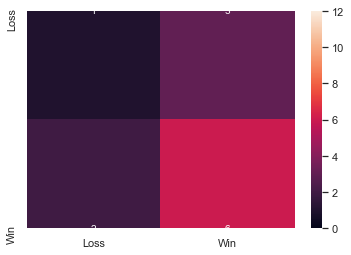

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary-test.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Model Score: 0.6666666666666666

ROC/AUC Score: 0.5625
              precision    recall  f1-score   support

        Loss       0.50      0.25      0.33         4
         Win       0.70      0.88      0.78         8

    accuracy                           0.67        12
   macro avg       0.60      0.56      0.56        12
weighted avg       0.63      0.67      0.63        12

      Loss  Win
Loss     1    3
Win      1    7


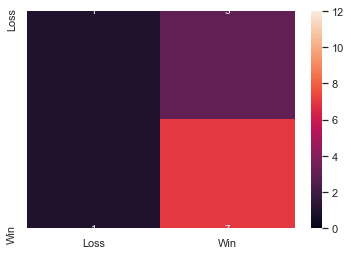

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary-test.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.1941            0.19s
         2           1.0659            0.15s
         3           0.9574            0.12s
         4           0.8664            0.10s
         5           0.7868            0.09s
         6           0.7163            0.08s
         7           0.6560            0.08s
         8           0.6029            0.07s


Model Score: 0.5

ROC/AUC Score: 0.4375
              precision    recall  f1-score   support

        Loss       0.25      0.25      0.25         4
         Win       0.62      0.62      0.62         8

    accuracy                           0.50        12
   macro avg       0.44      0.44      0.44        12
weighted avg       0.50      0.50      0.50        12

      Loss  Win
Loss     1    3
Win      3    5


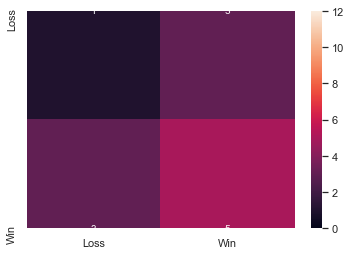

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary-test.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_ab = ab.predict()

Model Score: 0.5833333333333334

ROC/AUC Score: 0.5
              precision    recall  f1-score   support

        Loss       0.33      0.25      0.29         4
         Win       0.67      0.75      0.71         8

    accuracy                           0.58        12
   macro avg       0.50      0.50      0.50        12
weighted avg       0.56      0.58      0.57        12

      Loss  Win
Loss     1    3
Win      2    6


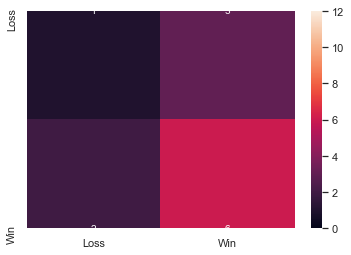

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary-test.csv


# Results


In [29]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min,data_filter_file
84,LogisticRegression,ohe-history_all-test,../datasets/atp_matches_1985-2019_features_tes...,1998,2018,0.583333,0.5625,"{""0"": {""0"": 2, ""1"": 3}, ""1"": {""0"": 2, ""1"": 5}}","{""Loss"": {""precision"": 0.4, ""recall"": 0.5, ""f1...",../models/logisticregression-1998-2018-ohe-his...,0.0,0.0,0.0,../models/logisticregression-1998-2018-ohe-his...
85,KNeighborsClassifier,ohe-history_all-test,../datasets/atp_matches_1985-2019_features_tes...,1998,2018,0.833333,0.7500,"{""0"": {""0"": 2, ""1"": 0}, ""1"": {""0"": 2, ""1"": 8}}","{""Loss"": {""precision"": 1.0, ""recall"": 0.5, ""f1...",../models/kneighborsclassifier-1998-2018-ohe-h...,0.0,0.0,0.0,../models/kneighborsclassifier-1998-2018-ohe-h...
86,DecisionTreeClassifier,ohe-history_all-test,../datasets/atp_matches_1985-2019_features_tes...,1998,2018,0.583333,0.5000,"{""0"": {""0"": 1, ""1"": 2}, ""1"": {""0"": 3, ""1"": 6}}","{""Loss"": {""precision"": 0.3333333333333333, ""re...",../models/decisiontreeclassifier-1998-2018-ohe...,0.0,0.0,0.0,../models/decisiontreeclassifier-1998-2018-ohe...
87,RandomForestClassifier,ohe-history_all-test,../datasets/atp_matches_1985-2019_features_tes...,1998,2018,0.666667,0.5625,"{""0"": {""0"": 1, ""1"": 1}, ""1"": {""0"": 3, ""1"": 7}}","{""Loss"": {""precision"": 0.5, ""recall"": 0.25, ""f...",../models/randomforestclassifier-1998-2018-ohe...,0.0,0.0,0.0,../models/randomforestclassifier-1998-2018-ohe...
88,GradientBoostingClassifier,ohe-history_all-test,../datasets/atp_matches_1985-2019_features_tes...,1998,2018,0.500000,0.4375,"{""0"": {""0"": 1, ""1"": 3}, ""1"": {""0"": 3, ""1"": 5}}","{""Loss"": {""precision"": 0.25, ""recall"": 0.25, ""...",../models/gradientboostingclassifier-1998-2018...,0.0,0.0,0.0,../models/gradientboostingclassifier-1998-2018...
89,AdaBoostClassifier,ohe-history_all-test,../datasets/atp_matches_1985-2019_features_tes...,1998,2018,0.583333,0.5000,"{""0"": {""0"": 1, ""1"": 2}, ""1"": {""0"": 3, ""1"": 6}}","{""Loss"": {""precision"": 0.3333333333333333, ""re...",../models/adaboostclassifier-1998-2018-ohe-his...,0.0,0.0,0.0,../models/adaboostclassifier-1998-2018-ohe-his...


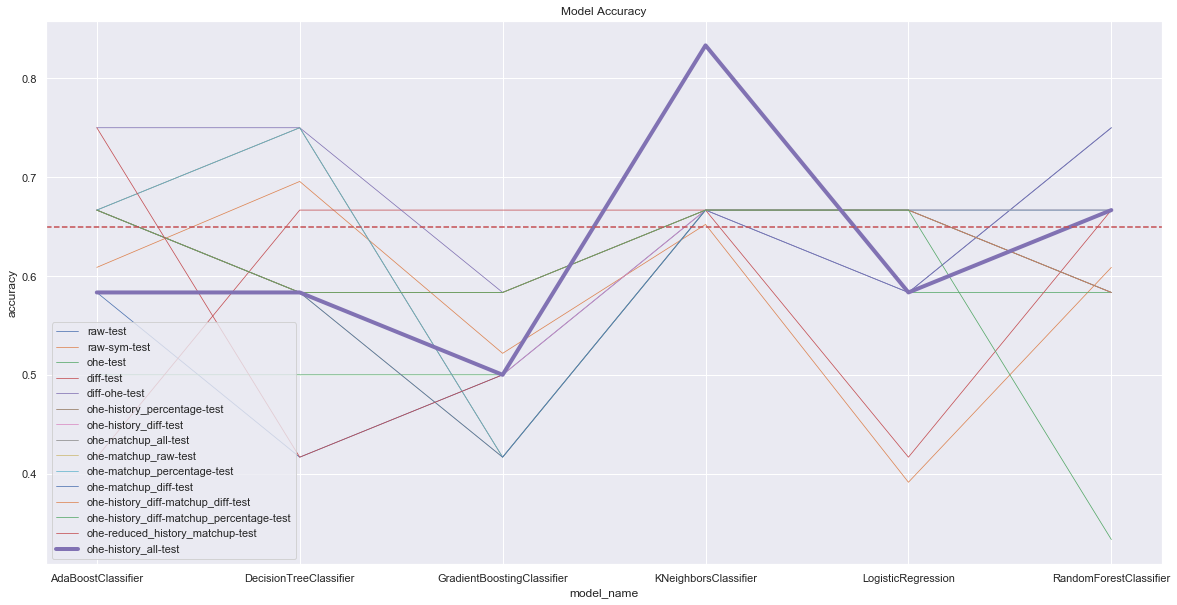

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: KNeighborsClassifier


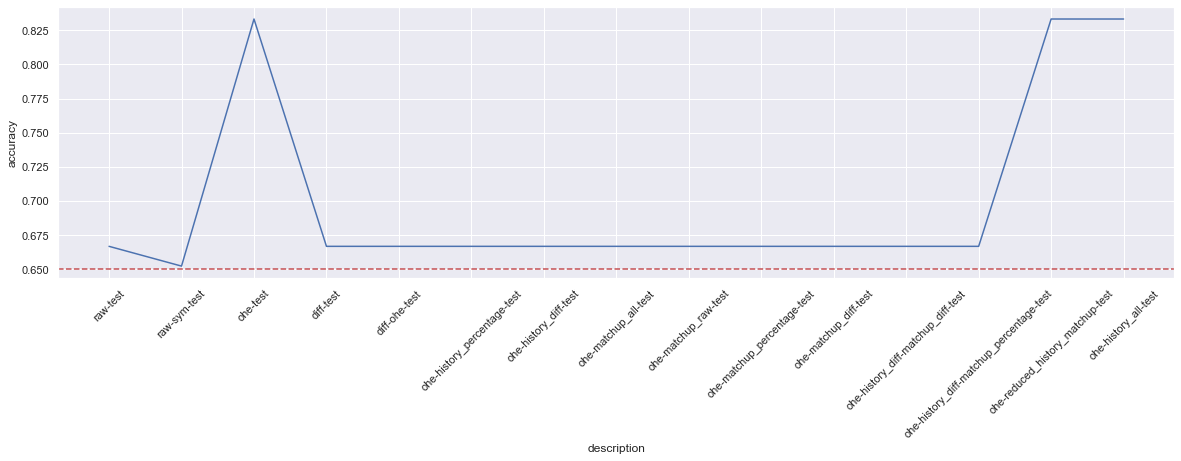

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

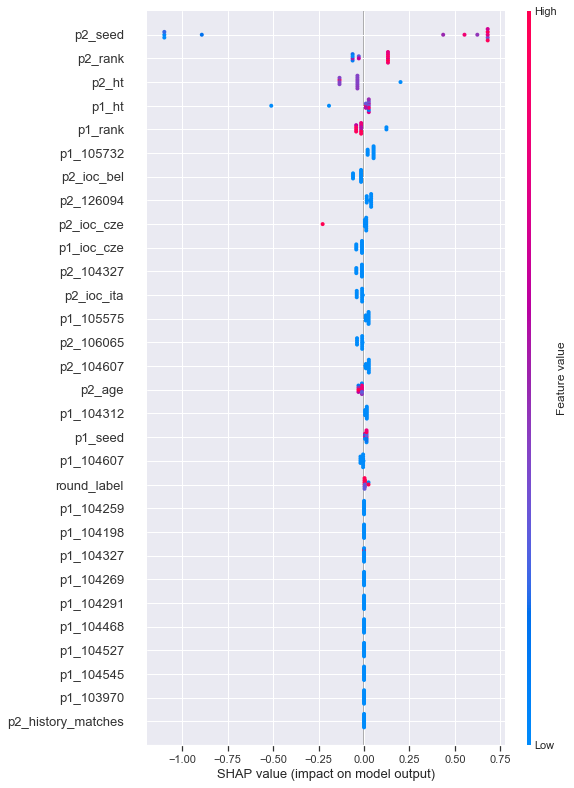

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

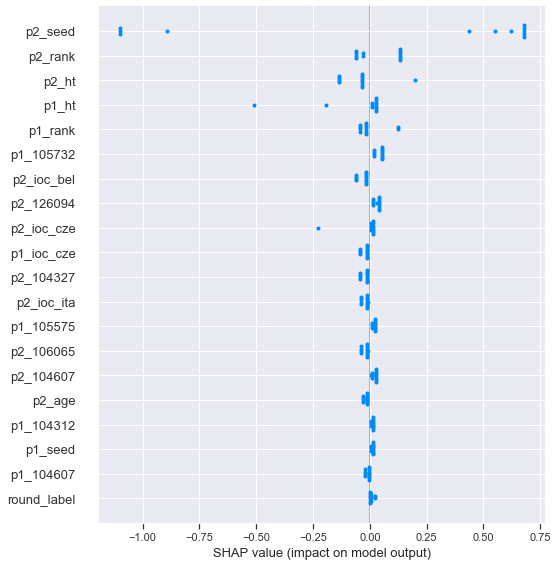

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-24 01:49
